# Controle preditivo e minimum jerk

O presente notebook procura apresentar os resultados obtidos com o uso de controle preditivo mais geração de trajetória com o princípio do tranco mínimo em árvores cinemátivas.

## Geração de Trajetórias
Para criação das trajetórias utilizando o princípio do tranco mínimo foi criado um módulo responsável por gerar as unções de trajetórias que serão utilizadas no controlador.

A seguir são carregados o módulo criado e o módulo Plots pra geração de gráficos.

In [2]:
push!(LOAD_PATH, pwd()*"/../modules")

using Trajetorias
using Plots
pyplot();

Agora que temos os módulos carregados será feita uma demostração de como serão geradas as trajetórias utilizando o módulo.

Primeiro determinamos a posição, velocidade e aceleração inicial desejadas bem como as finais, em seguida utilizamos a função ___minimumjerk___ para calcular os coeficientes do polinômio.

In [3]:
x0 = 0.  #-> posição inicial
v0 = 0.  #-> velocidade inicial
a0 = 0.  #-> aceleração inicial
t0 = 0.  #-> tempo no instante inicial
xf = 10. #-> posição final
vf = 0.  #-> velocidade final
af = 0.  #-> aceleração final
tf = 12. #-> tempo para chegar ao ponto final
coeficientes = minimumjerk(x0,v0,a0,t0,xf,vf,af,tf)

6-element Array{Float64,1}:
  0.0        
  0.0        
  0.0        
  0.0578704  
 -0.0072338  
  0.000241127

Com os coeficientes do polinômio agora podemos obter as funções de trajetória, velocidade e aceleração através da função ___functionform___ :

In [4]:
posicao, velocidade, aceleracao = functionform(coeficientes);

Agora temos as funções desejadas, mostraremos o perfil destas a seguir:


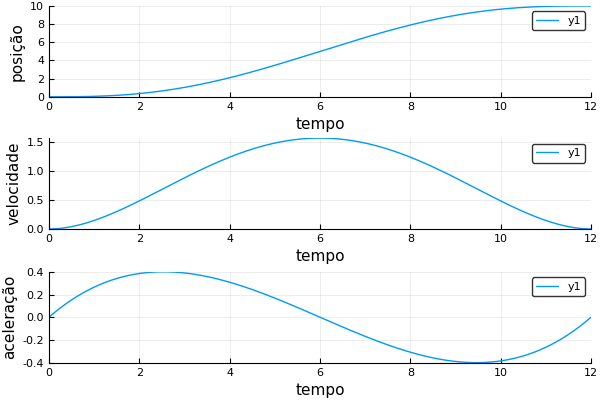

In [5]:
time = 0:0.01:tf
p1 = plot(time, map(posicao,time), xlabel = "tempo", ylabel ="posição")
p2 = plot(time, map(velocidade,time), xlabel = "tempo", ylabel ="velocidade")
p3 = plot(time, map(aceleracao,time), xlabel = "tempo", ylabel ="aceleração")
plot(p1, p2, p3, layout=(3,1))


Agora que já foi mostrado como utilizar o módulo criado para obter as funções de trajetória com base no mínimo tranco iniciaremos a parte do controlador preditivo.


# Controle Preditivo de Árvores Cinemáticas

O controle preditivo não costuma ser muito utilizado para tarefas que envolvem árvores cinemáticas (maniuladores industriais e mecanismos de barras por exemplo), decido principalmente ao alto custo computacional necessário para realizar a tarefa de controle em sistemas deste tipo. Porém Vicent Duchaine mostrou em seu artigo uma forma de utilizar o controle preditivo para esses sistemas e é esta forma que será utilizada aqui.

Antes de começarmos a apresentar o controlador em si, é necessário primeiro apresentar a dinâmica do sistema. Árvores cinemáticas apresentam a seguinte equação de dinâmica:

$$\Gamma = M(q)\dot q + h_n(q,\dot q)$$

Onde $\Gamma$ é o vetor de torques/forças atuando sobre o sistema, $M(q)$ é a matriz de inércia generalizada e $h_n(q,\dot q)$ é termo de gravidade, Coriolis, fricção e centripeta.


O controlador preditivo proposto por Duchaine é da forma:

$$ \Gamma = h_n - \frac{2M(P_2\dot q T_s + q - r + P_3 \Delta r + d)}{P_1 T_s^2}$$
com
$$P_1 = \frac{3H_p^2+3H_p-1}{5}$$
$$P_2 = \frac{3H_p(H_p+1)}{2(2H_p+1)}$$
$$P_3 = \frac{-3H_p^2+H_p+2}{4H_p+2}$$


onde $H_p$ é o horizonte de previsão, $T_s$ é o período de discretização e $d$ é a diferença entre a saída real e a saída do modelo(erro), $r$ é a referência inicial e $\Delta r$ é um valor utilizado quando for trabalhar com trajetória será explicado melhor a seguir.

O controlador necessita das referências desejadas poreḿ no controlador preditivo utilizado ele faz uma linearização da trajetória dentro do horizonte de predição para que não seja necessário ficar computando o valor desejado a cada novo período de discretização, desta forma é feita uma linearização dentro do intervalo de predição e escolhido um valor $\Delta r$ que será somado a referência a cada intervalo de discretização, assim temos:
$$\hat r(k) = r(k)$$
$$\hat r(k+1) = r(k) + \Delta r$$
$$\hat r(k+2) = r(k) + 2\Delta r$$
$$\vdots$$
$$\hat r(k+n) = r(k) + n\Delta r$$.

Portanto esse valor deverá ser escolhido de forma adequada conforme o horizonte de predição e o tempo de discretização.

Criaremos uma função para fazer a tarefa do controlador:

In [6]:
function controlador(hₙ,M,q,dot_q,r,Δr,d,Tₛ,Hₚ)
    P1 = (3*(Hₚ^2) + 3*Hₚ - 1)/5
    P2 = (3*Hₚ*(Hₚ + 1))/(2*(2*Hₚ + 1))
    P3 = (-3*(Hₚ^2) + Hₚ + 2)/(4*Hₚ + 2)
    τ = hₙ - (2*M*(P2*dot_q*Tₛ + q - r + P3*Δr + d))/(P1*(Tₛ^2))
end

controlador (generic function with 1 method)

Agora temos a função que fornecerá o valor de entrada que será utilizado para movimentar as juntas, o próximo passo será fornecer um modelo para realizar a simulação.

# Modelo do robô
Para realizar a simlação será utilizado o modelo de um robô do tipo KUKA de sete graus de liberdade, para isto carregaremos o pacote de dinâmica e carregaremos o urdf contendo as informaçãoes de dinâmica do manipulador.


In [10]:
using RigidBodyDynamics
urdf = "../urdf/kuka.urdf"
mecanismo = parse_urdf(Float64, urdf)
state = MechanismState(mecanismo);

Agora temos o nosso robô KUKA carregado, podemos verificar as juntas e corpos que compõem este:

In [14]:
collect(bodies(mecanismo))

9-element Array{RigidBodyDynamics.RigidBody{Float64},1}:
 RigidBody: "world"                   
 RigidBody: "calib_kuka_arm_base_link"
 RigidBody: "kuka_arm_1_link"         
 RigidBody: "kuka_arm_2_link"         
 RigidBody: "kuka_arm_3_link"         
 RigidBody: "kuka_arm_4_link"         
 RigidBody: "kuka_arm_5_link"         
 RigidBody: "kuka_arm_6_link"         
 RigidBody: "kuka_arm_7_link"         

In [15]:
collect(joints(mecanismo))

8-element Array{RigidBodyDynamics.Joint{Float64,RigidBodyDynamics.JointType{Float64}},1}:
 Joint "calib_kuka_arm_base_link_to_world": Fixed joint             
 Joint "kuka_arm_0_joint": Revolute joint with axis [0.0, 0.0, 1.0] 
 Joint "kuka_arm_1_joint": Revolute joint with axis [0.0, -1.0, 0.0]
 Joint "kuka_arm_2_joint": Revolute joint with axis [0.0, 0.0, 1.0] 
 Joint "kuka_arm_3_joint": Revolute joint with axis [0.0, 1.0, 0.0] 
 Joint "kuka_arm_4_joint": Revolute joint with axis [0.0, 0.0, 1.0] 
 Joint "kuka_arm_5_joint": Revolute joint with axis [0.0, -1.0, 0.0]
 Joint "kuka_arm_6_joint": Revolute joint with axis [0.0, 0.0, 1.0] 

Podemos modificar a posição e velocidade das juntas do mecanismos:

In [19]:
set_configuration!(state,[0.3, 0.4,0.3, 0.4,0.3, 0.4, 0.3])
set_velocity!(state,[1.,1.,1.,1.,1.,1.,1.]);

E podemos fazer uma leitura do estado atual de posição e velocidade das juntas:

In [21]:
configuration(state)

7-element Array{Float64,1}:
 0.3
 0.4
 0.3
 0.4
 0.3
 0.4
 0.3

In [22]:
velocity(state)

7-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

Tendo a posição e velocidade do mecanismo em determinado momento também é possível calcular a matriz de massa $M$ e o vetor de viés dinâmico $h_n$:

In [23]:
mass_matrix(state)

7×7 Symmetric{Float64,Array{Float64,2}}:
  0.318805      0.215975    -0.116273     …   0.021039      0.000778355
  0.215975      4.35831      0.225189         0.114125      8.76724e-5 
 -0.116273      0.225189     0.149051        -0.00854442    0.000827689
 -0.229444     -1.82373     -0.00900794      -0.0709309    -9.59008e-5 
  0.0228421    -0.00690237  -0.00116487      -7.02563e-17   0.000767551
  0.021039      0.114125    -0.00854442   …   0.0182097     5.92245e-18
  0.000778355   8.76724e-5   0.000827689      5.92245e-18   0.000833333

In [25]:
dynamics_bias(state)

7-element Array{Float64,1}:
   0.875725   
 -14.6053     
  -1.3061     
  -0.618316   
   0.104249   
  -0.442519   
  -0.000692425

Agora que temos a dinâmica do sistema iniciaremos a parte de simulação.

# Simulação do sistema
Para fazer a simulação do controlador agindo sobre o robô KUKA faremos uso de u módulo para resolução de equações diferenciais, econsideraremos que o valor de torque só é modificado durante os períodos de discretização, assim como seria no robô verdadeiro. 

